# Determing Support for Rumours using Tweets 

In [2]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt

# Tensorboard

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

%load_ext tensorboard

%tensorboard --logdir {logdir}/model

In [4]:
# setting up callbacks
m_histories = {}

def get_callbacks(name):
  return [
      tf.keras.callbacks.TensorBoard(log_dir = logdir/name, histogram_freq=1),
  ]

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
!cp /content/drive/MyDrive/COSC2779/Assessment_2/Rumour_data.zip .
!unzip -q -o Rumour_data.zip
!rm Rumour_data.zip

In [648]:
data = pd.read_csv('./Rumour_data/twitter_dataset.csv')
data_extra = pd.read_csv('./Rumour_data/Extra_reddit_dataset.csv')

In [649]:
data.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
0,Source,5.810630e+17,-1.000000e+00,#4U9525: Robin names Andreas Lubitz as the cop...,germanwings-crash,-1
1,Reply,5.810700e+17,5.810630e+17,@thatjohn Have they named the pilot?,germanwings-crash,query
2,Reply,5.810640e+17,5.810630e+17,@thatjohn @mschenk,germanwings-crash,comment
3,Source,5.813860e+17,-1.000000e+00,RT @khjelmgaard: German media reporting #Andre...,germanwings-crash,-1
4,Reply,5.815760e+17,5.813860e+17,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,germanwings-crash,comment


In [650]:
data = data[(data['Class'] != "-1")]

In [96]:
data.shape

(6253, 6)

### Distribution of Labels

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

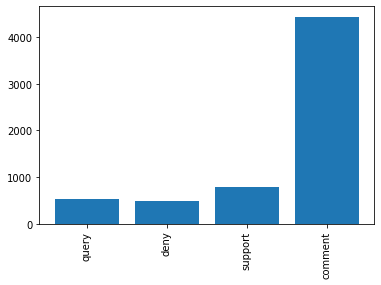

In [675]:
data_viz = pd.DataFrame(data)
data_bar = data_viz['Class'].value_counts(sort=False).values
labels = ['query', 'deny', 'support', 'comment']
plt.bar(labels, data_bar)
plt.xticks(rotation=90)

In [692]:
data['Class'].value_counts()

comment    4445
support     792
query       520
deny        496
Name: Class, dtype: int64

# Data Preprocessing

In [99]:
encode = {
    "comment" : 0,
    "support"  : 1,       
    "query" : 2,    
    "deny" : 3,
}

data["Class"] = data["Class"].apply(lambda x: encode[x])
data.head()

,Type,Msg_ID,Source_Msg_ID,Text,Topic,Class
1,Reply,5.810700e+17,5.810630e+17,@thatjohn Have they named the pilot?,germanwings-crash,2
2,Reply,5.810640e+17,5.810630e+17,@thatjohn @mschenk,germanwings-crash,0
4,Reply,5.815760e+17,5.813860e+17,@tinkalee_12 @USATODAY @khjelmgaard #F4Phantom...,germanwings-crash,0
5,Reply,5.820480e+17,5.813860e+17,@USATODAY @khjelmgaard ers a link to prove @An...,germanwings-crash,0
6,Reply,5.822060e+17,5.813860e+17,@USATODAY @khjelmgaard Sure #GermanWings CoPil...,germanwings-crash,0


In [100]:
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

happy_lines = list()
lines = data["Text"].values.tolist()

for line in lines:
    # tokenize the text
    tokens = word_tokenize(line)

    # convert to lower case
    tokens = [w.lower() for w in tokens]

    # remove puntuations
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove non alphabetic characters
    words = [word for word in stripped if word.isalpha()]

    happy_lines.append(words)
    

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
len(happy_lines)

6253

Maximum sentence length

In [640]:
sentence_length = []
for sentence in np.arange(0,6253):
  x = len(happy_lines[sentence])
  sentence_length.append(x)
sentence_length = np.array(sentence_length)

(array([  4.,  80., 239., 221., 236., 240., 252., 265., 284., 245., 252.,
        270., 270., 253., 289., 307., 316., 327., 315., 288., 299., 267.,
        221., 173., 125.,  91.,  61.,  38.,  16.,   9.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <a list of 30 Patch objects>)

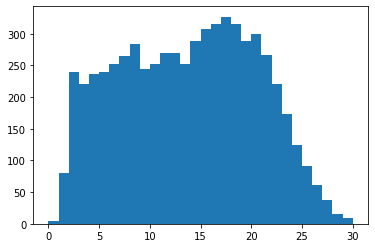

In [641]:
plt.hist(sentence_length, 30)

In [645]:
print(max(sentence_length))

30


In [104]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

split = 0.10
max_length = 30

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(happy_lines)
sequences = tokenizer_obj.texts_to_sequences(happy_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
category =  data['Class'].values

unique tokens - 9883
vocab_size - 9884


In [107]:
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
category = category[indices]

n_values = np.max(category) + 1
Y = np.eye(n_values)[category]

split_samples = int(split * lines_pad.shape[0])

X_train_pad = lines_pad[:-split_samples*2]
y_train = Y[:-split_samples*2]
X_val_pad = lines_pad[-split_samples*2:-split_samples]
y_val = Y[-split_samples*2:-split_samples]
X_test_pad = lines_pad[-split_samples:]
y_test = Y[-split_samples:]

In [109]:
# saving data after random split so the data is the same between sessions

# np.save('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/X_train.npy', X_train_pad)
# np.save('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/y_train.npy', y_train)
# np.save('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/X_val.npy', X_val_pad)
# np.save('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/y_val.npy', y_val)
# np.save('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/X_test.npy', X_test_pad)
# np.save('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/y_test.npy', y_test)

In [157]:
X_train_pad = np.load('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/X_train.npy')
y_train = np.load('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/y_train.npy')
X_val_pad = np.load('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/X_val.npy')
y_val = np.load('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/y_val.npy')
X_test_pad = np.load('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/X_test.npy')
y_test = np.load('/content/drive/MyDrive/COSC2779/Assessment_2/split_data/y_test.npy')

In [158]:
X_train_pad

array([[1528,   52,   21, ...,    0,    0,    0],
       [2811,   72,   10, ...,    0,    0,    0],
       [ 155, 1650, 1647, ...,    0,    0,    0],
       ...,
       [ 288, 3805,   67, ...,    0,    0,    0],
       [1702, 3889,   48, ...,    0,    0,    0],
       [ 408, 4308,  610, ...,    0,    0,    0]], dtype=int32)

In [162]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [159]:
X_val_pad

array([[ 628,  122, 2566, ...,    0,    0,    0],
       [3937,  406,  215, ...,    0,    0,    0],
       [2439, 1694,  101, ...,    0,    0,    0],
       ...,
       [2406,  681,   98, ...,    0,    0,    0],
       [ 658, 3524,    1, ...,    0,    0,    0],
       [1037,  728, 1219, ...,    0,    0,    0]], dtype=int32)

In [161]:
y_val

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [87]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_val_pad:', X_val_pad.shape)
print('Shape of y_val:', y_val.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (5003, 30)
Shape of y_train: (5003, 4)
Shape of X_val_pad: (625, 30)
Shape of y_val: (625, 4)
Shape of X_test_pad: (625, 30)
Shape of y_test: (625, 4)


# Models

## Embedding Layer

In [320]:
# default embedding for models
file = open('/content/drive/MyDrive/COSC2779/Assessment_2/glove.twitter.27B.100d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [251]:
file = open('/content/drive/MyDrive/COSC2779/Assessment_2/glove.twitter.27B.50d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [263]:
file = open('/content/drive/MyDrive/COSC2779/Assessment_2/glove.6B.50d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [275]:
file = open('/content/drive/MyDrive/COSC2779/Assessment_2/glove.6B.100d.txt', encoding='utf-8')

glove_vectors = dict()
for line in file:
  values = line.split()
  word = values[0]
  features = np.asarray(values[1:])
  glove_vectors[word] = features

file.close()

In [321]:
from tensorflow.keras.layers import Embedding
embedding_dim = 100

E_T = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        E_T[i] = embedding_vector

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [207]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv2D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_lstm = tf.keras.Sequential([
      embedding_layer_TL,
      LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
      LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
      LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
      LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),
      Dense(4, activation='softmax')
  ])

print(model_lstm.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
lstm (LSTM)                  (None, 30, 64)            42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 260       
Total params: 1,129,972
Trainable params: 141,572
Non-trainable params: 988,400
_______________________________________

In [514]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv2D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_lstm2 = tf.keras.Sequential([
      embedding_layer_TL,
      LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
      LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),
      Dense(4, activation='softmax')
  ])

print(model_lstm2.summary())

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
lstm_28 (LSTM)               (None, 30, 64)            42240     
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 260       
Total params: 1,063,924
Trainable params: 75,524
Non-trainable params: 988,400
_________________________________________________________________
None


## GRU Model

In [228]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv2D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_gru = tf.keras.Sequential([
      embedding_layer_TL,
      GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
      GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
      GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
      GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False),
      Dense(4, activation='softmax')
  ])

print(model_gru.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
gru_18 (GRU)                 (None, 30, 64)            31872     
_________________________________________________________________
gru_19 (GRU)                 (None, 30, 64)            24960     
_________________________________________________________________
gru_20 (GRU)                 (None, 30, 64)            24960     
_________________________________________________________________
gru_21 (GRU)                 (None, 64)                24960     
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 260       
Total params: 1,095,412
Trainable params: 107,012
Non-trainable params: 988,400
_______________________________________

## Bidirectional LSTM Model

In [231]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

model_bi_lstm = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
      Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)),
      Dense(64, activation='relu'),
      Dropout(.5),
      Dense(4, activation='softmax')
  ])

print(model_bi_lstm.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 260       
Total params: 1,180,212
Trainable params: 191,812
Non-trainable params: 988,400
_______________________________________

In [241]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

model_bi_lstm2 = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)),
      Bidirectional(LSTM(64, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
      Dense(64, activation='relu'),
      Dropout(.5),
      Dense(4, activation='softmax')
  ])

print(model_bi_lstm2.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 30, 128)           84480     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 260       
Total params: 1,180,212
Trainable params: 191,812
Non-trainable params: 988,400
_______________________________________

## Bidirectional GRU Models

In [227]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv1D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_bi_gru = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
      Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)),
      Dense(64, activation='relu'),
      Dropout(.3),
      Dense(4, activation='softmax')
  ])

print(model_bi_gru.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 30, 128)           63744     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 128)               74496     
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 260       
Total params: 1,135,156
Trainable params: 146,756
Non-trainable params: 988,400
_______________________________________

### Alternative Architecture

In [368]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv1D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_bi_gru2 = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
      Dense(32, activation='relu'),
      Dropout(.5),
      Dense(4, activation='softmax')
  ])

print(model_bi_gru2.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 256)               176640    
_________________________________________________________________
dense_59 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 132       
Total params: 1,173,396
Trainable params: 184,996
Non-trainable params: 988,400
_________________________________________________________________
None


### With Alternative Embedding Layers

In [253]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv1D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_bi_gru2_twitter50d = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
      Dense(32, activation='relu'),
      Dropout(.5),
      Dense(4, activation='softmax')
  ])

print(model_bi_gru2_twitter50d.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 30, 50)            494200    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 256)               138240    
_________________________________________________________________
dense_29 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 132       
Total params: 640,796
Trainable params: 146,596
Non-trainable params: 494,200
_________________________________________________________________
None


In [265]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv1D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_bi_gru2_glove50d = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
      Dense(32, activation='relu'),
      Dropout(.5),
      Dense(4, activation='softmax')
  ])

print(model_bi_gru2_glove50d.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 30, 50)            494200    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 256)               138240    
_________________________________________________________________
dense_31 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 132       
Total params: 640,796
Trainable params: 146,596
Non-trainable params: 494,200
_________________________________________________________________
None


In [277]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv1D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_bi_gru2_glove100d = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(GRU(128, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)),
      Dense(32, activation='relu'),
      Dropout(.5),
      Dense(4, activation='softmax')
  ])

print(model_bi_gru2_glove100d.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 256)               176640    
_________________________________________________________________
dense_33 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 132       
Total params: 1,173,396
Trainable params: 184,996
Non-trainable params: 988,400
_________________________________________________________________
None


## Bidirectional LSTM Models with CNN

In [322]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv1D, Attention
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_cnn_bi_lstm = tf.keras.Sequential([
      embedding_layer_TL,
      Conv1D(filters=64, kernel_size=3, activation="relu"),
      Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
      Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)),
      Dense(64, activation='relu'),
      Dropout(.3),
      Dense(4, activation='softmax')
  ])

print(model_cnn_bi_lstm.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 28, 64)            19264     
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 28, 128)           66048     
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 4)               

In [344]:
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Dropout, Conv1D, Attention, Flatten
from tensorflow.keras.models import Sequential

embedding_layer_TL = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[E_T],
                            input_length=max_length,
                            trainable=False)

model_bi_lstm_cnn = tf.keras.Sequential([
      embedding_layer_TL,
      Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)),
      Conv1D(filters=32, kernel_size=3, activation="relu"),
      MaxPool1D(2),
      Conv1D(filters=32, kernel_size=3, activation="relu"),
      MaxPool1D(2),
      Conv1D(filters=64, kernel_size=3, activation="relu"),
      MaxPool1D(2),
      Flatten(),
      Dense(64, activation='relu'),
      Dropout(.3),
      Dense(4, activation='softmax')
  ])

print(model_bi_lstm_cnn.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 30, 100)           988400    
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 30, 128)           84480     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 28, 32)            12320     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 14, 32)            0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 12, 32)            3104      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 6, 32)             0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 4, 64)           

In [119]:
import os
checkpoint_path = "training_1/cp_01.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Model Fitting

In [ ]:
model_bi_lstm.compile(loss='categorical_crossentropy', 
                    optimizer='adam', 
                    metrics=[tf.losses.CategoricalCrossentropy(name='CategoricalCrossentropy'), 
                             tf.keras.metrics.AUC(name='auc'), 'accuracy'])

m_histories = model_bi_lstm.fit(X_train_pad, y_train, batch_size=32, epochs=100, validation_data=(X_val_pad, y_val), callbacks=[get_callbacks('model/attempt'), cp_callback], verbose=1)

# Model Learning History

In [ ]:
hist_df = pd.DataFrame(model_lstm.history.history) 
hist_df

In [524]:
#hist_csv_file = '/content/drive/MyDrive/COSC2779/Assessment_2/model_lstm_twitter100.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [525]:
#model_lstm.save('/content/drive/MyDrive/COSC2779/Assessment_2/model_lstm_twitter100.h5')

# Model Results

In [572]:
def plot_model(df, metric, name, specific):
  multiplier = 1
  if metric == "accuracy":
    multiplier = 100
  
  plt.plot(df[metric]*multiplier, color='blue', linestyle='solid', label='Training')
  plt.plot(df['val_' + metric]*multiplier, color='blue', linestyle='dashed', label='Validation')
  plt.title('Model ' + metric.capitalize() + " for " + name + ' Models')
  plt.xlabel('Epoch')
  plt.grid(True)

  if metric == "accuracy":
    plt.ylabel('Accuracy (%)')
  elif metric == "CategoricalCrossentropy":
    plt.ylabel('Categorical Crossentropy')
  elif metric == "auc":
    plt.ylabel('AUC')

def add_model(df, metric, colour):
  multiplier = 1
  if metric == "accuracy":
    multiplier = 100
  plt.plot(df[metric]*multiplier, color=colour, linestyle='solid', label='Train')
  plt.plot(df['val_' + metric]*multiplier, color=colour, linestyle='dashed', label='Validation')

## Simple LSTM Models

In [212]:
lstm_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_lstm_twitter100.csv')
lstm2_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_lstm2_twitter100.csv')

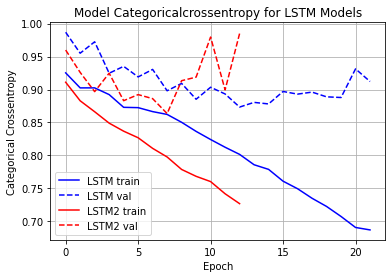

In [581]:
plot_model(lstm_results, 'CategoricalCrossentropy', "LSTM")
add_model(lstm2_results, 'CategoricalCrossentropy', 'red')
plt.legend(['LSTM train', 'LSTM val', 'LSTM2 train', 'LSTM2 val'])

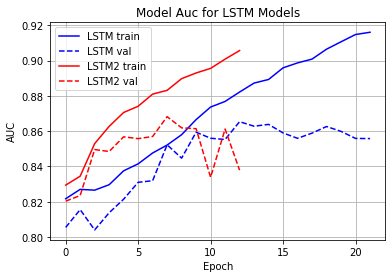

In [582]:
plot_model(lstm_results, 'auc', "LSTM")
add_model(lstm2_results, 'auc', 'red')
plt.legend(['LSTM train', 'LSTM val', 'LSTM2 train', 'LSTM2 val'])

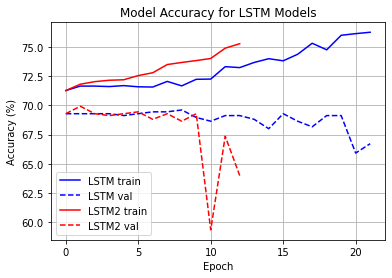

In [579]:
plot_model(lstm_results, 'accuracy', "LSTM")
add_model(lstm2_results, 'accuracy', 'red')
plt.legend(['LSTM train', 'LSTM val', 'LSTM2 train', 'LSTM2 val'])

In [216]:
lstm_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.925294,0.821648,0.712572,0.986959,0.805411,0.6928
1,0.902492,0.826969,0.716370,0.955122,0.815485,0.6928
2,0.902526,0.826525,0.716370,0.972428,0.803987,0.6928
3,0.892317,0.829607,0.715970,0.924746,0.813717,0.6928
4,0.872984,0.837493,0.716770,0.935178,0.821401,0.6912
5,0.872508,0.841439,0.715771,0.919130,0.830971,0.6928
6,0.866489,0.847589,0.715571,0.930527,0.831885,0.6944
7,0.862219,0.852089,0.720368,0.898126,0.852229,0.6944
8,0.850248,0.857962,0.716570,0.909292,0.844659,0.6960
9,0.836467,0.866518,0.722167,0.885254,0.859374,0.6896


In [530]:
lstm2_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.911067,0.829365,0.712572,0.959916,0.820284,0.6928
1,0.882921,0.834439,0.717969,0.925999,0.823481,0.6992
2,0.866309,0.852898,0.720168,0.896820,0.849544,0.6928
3,0.848992,0.862675,0.721367,0.924796,0.848432,0.6912
4,0.836790,0.870550,0.721767,0.883064,0.856761,0.6928
5,0.826800,0.874081,0.725365,0.892294,0.855718,0.6944
6,0.810703,0.880965,0.727763,0.886173,0.856943,0.6880
7,0.797619,0.883108,0.734759,0.863519,0.868181,0.6928
8,0.778672,0.889724,0.736558,0.913407,0.861842,0.6864
9,0.768259,0.892953,0.738157,0.918843,0.861359,0.6928


## Simple GRU Model

In [222]:
gru_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_gru_twitter100.csv')

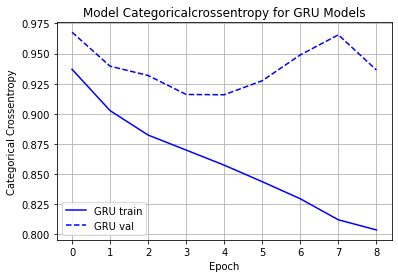

In [587]:
plot_model(gru_results, 'CategoricalCrossentropy', "GRU")
plt.legend(['GRU train', 'GRU val'])

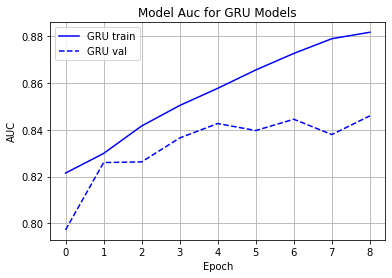

In [588]:
plot_model(gru_results, 'auc', "GRU")
plt.legend(['GRU train', 'GRU val'])

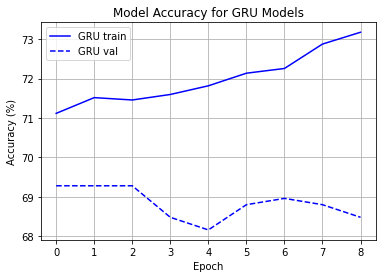

In [586]:
plot_model(gru_results, 'accuracy', "GRU")
plt.legend(['GRU train', 'GRU val'])

In [226]:
gru_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.936933,0.821502,0.711173,0.967707,0.797188,0.6928
1,0.902602,0.829897,0.715171,0.939506,0.825993,0.6928
2,0.882328,0.841640,0.714571,0.931790,0.826277,0.6928
3,0.869856,0.850400,0.715970,0.916041,0.836515,0.6848
4,0.857337,0.857756,0.718169,0.915793,0.842688,0.6816
5,0.843608,0.865603,0.721367,0.927465,0.839697,0.6880
6,0.829423,0.872675,0.722566,0.948903,0.844516,0.6896
7,0.811955,0.878968,0.728763,0.965555,0.837970,0.6880
8,0.803563,0.881732,0.731761,0.936352,0.845972,0.6848


## Bidirectional LSTM

In [594]:
lstm_bi_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_lstm_twitter100.csv')
lstm_bi2_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_lstm2_twitter100.csv')

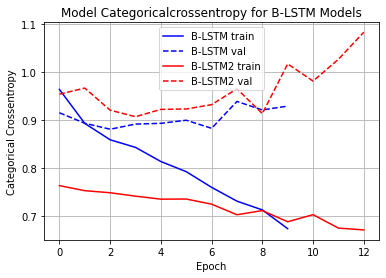

In [685]:
plot_model(lstm_bi_results, 'CategoricalCrossentropy', "B-LSTM")
add_model(lstm_bi2_results, 'CategoricalCrossentropy', 'red')
plt.legend(['B-LSTM train', 'B-LSTM val', 'B-LSTM2 train', 'B-LSTM2 val'])

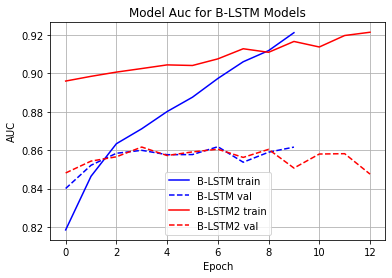

In [686]:
plot_model(lstm_bi_results, 'auc', "B-LSTM")
add_model(lstm_bi2_results, 'auc', 'red')
plt.legend(['B-LSTM train', 'B-LSTM val', 'B-LSTM2 train', 'B-LSTM2 val'])

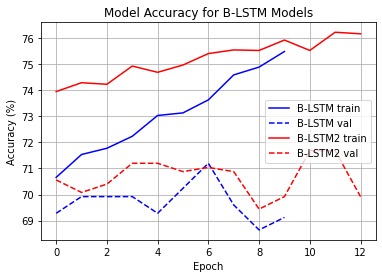

In [687]:
plot_model(lstm_bi_results, 'accuracy', "B-LSTM")
add_model(lstm_bi2_results, 'accuracy', 'red')
plt.legend(['B-LSTM train', 'B-LSTM val', 'B-LSTM2 train', 'B-LSTM2 val'])

In [240]:
lstm_bi[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.963492,0.818425,0.706576,0.914952,0.840000,0.6928
1,0.892828,0.846379,0.715371,0.893170,0.852112,0.6992
2,0.858840,0.863327,0.717769,0.880787,0.858351,0.6992
3,0.843062,0.871122,0.722367,0.891458,0.859883,0.6992
4,0.813651,0.880088,0.730362,0.893015,0.857608,0.6928
5,0.792573,0.887570,0.731361,0.899459,0.857682,0.7024
6,0.759986,0.897323,0.736358,0.882699,0.861770,0.7120
7,0.731285,0.906030,0.745952,0.938519,0.853692,0.6960
8,0.713122,0.911836,0.748951,0.920828,0.858913,0.6864
9,0.674108,0.921174,0.754947,0.928857,0.861574,0.6912


In [250]:
lstm_bi2[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.949144,0.823469,0.713172,0.907618,0.844416,0.6896
1,0.887255,0.846081,0.715171,0.916289,0.851939,0.6912
2,0.875252,0.853796,0.721167,0.910402,0.846115,0.6880
3,0.862485,0.859771,0.724765,0.876170,0.862159,0.6928
4,0.848051,0.865260,0.721167,0.886267,0.857358,0.6928
5,0.843015,0.867950,0.723966,0.904747,0.852038,0.6912
6,0.835935,0.871462,0.726364,0.884993,0.859943,0.6976
7,0.820480,0.877860,0.728363,0.900015,0.853206,0.7008
8,0.810318,0.880596,0.725165,0.888124,0.857999,0.7008
9,0.804211,0.883582,0.733960,0.877137,0.858368,0.7024


## Bidirectional GRU Models

In [615]:
model_bi_gru_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_gru_twitter100.csv')
model_bi_gru2_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_gru2_twitter100.csv')
model_bi_gru2_twitter50_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_gru2_twitter50.csv')
model_bi_gru2_glove_50_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_gru2_glove50.csv')
model_bi_gru2_glove_100_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_gru2_glove100.csv')

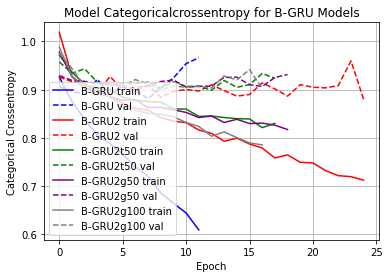

In [688]:
plot_model(model_bi_gru_results, 'CategoricalCrossentropy', "B-GRU")
add_model(model_bi_gru2_results, 'CategoricalCrossentropy', 'red')
add_model(model_bi_gru2_twitter50_results, 'CategoricalCrossentropy', 'green')
add_model(model_bi_gru2_glove_50_results, 'CategoricalCrossentropy', 'purple')
add_model(model_bi_gru2_glove_100_results, 'CategoricalCrossentropy', 'grey')
plt.legend(['B-GRU train', 'B-GRU val', 'B-GRU2 train', 'B-GRU2 val', 
            'B-GRU2t50 train', 'B-GRU2t50 val', 'B-GRU2g50 train', 
            'B-GRU2g50 val', 'B-GRU2g100 train', 'B-GRU2g100 val'],loc='lower left')

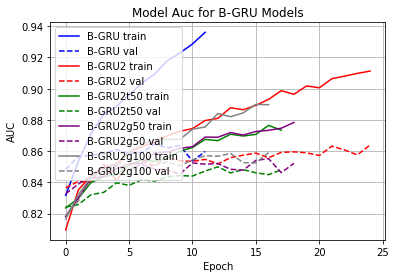

In [689]:
plot_model(model_bi_gru_results, 'auc', "B-GRU")
add_model(model_bi_gru2_results, 'auc', 'red')
add_model(model_bi_gru2_twitter50_results, 'auc', 'green')
add_model(model_bi_gru2_glove_50_results, 'auc', 'purple')
add_model(model_bi_gru2_glove_100_results, 'auc', 'grey')
plt.legend(['B-GRU train', 'B-GRU val', 'B-GRU2 train', 'B-GRU2 val', 
            'B-GRU2t50 train', 'B-GRU2t50 val', 'B-GRU2g50 train', 
            'B-GRU2g50 val', 'B-GRU2g100 train', 'B-GRU2g100 val'],loc='upper left')

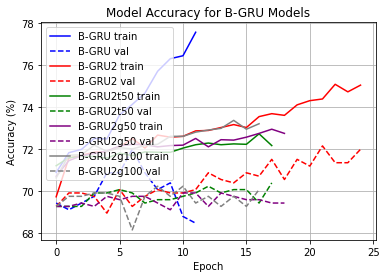

In [690]:
plot_model(model_bi_gru_results, 'accuracy', "B-GRU")
add_model(model_bi_gru2_results, 'accuracy', 'red')
add_model(model_bi_gru2_twitter50_results, 'accuracy', 'green')
add_model(model_bi_gru2_glove_50_results, 'accuracy', 'purple')
add_model(model_bi_gru2_glove_100_results, 'accuracy', 'grey')
plt.legend(['B-GRU train', 'B-GRU val', 'B-GRU2 train', 'B-GRU2 val', 
            'B-GRU2t50 train', 'B-GRU2t50 val', 'B-GRU2g50 train', 
            'B-GRU2g50 val', 'B-GRU2g100 train', 'B-GRU2g100 val'],loc='upper left')

In [512]:
model_bi_gru_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.926139,0.831675,0.708975,0.906655,0.848350,0.6944
1,0.875930,0.853423,0.718369,0.896687,0.856627,0.6912
2,0.838312,0.871236,0.719968,0.890560,0.857301,0.6944
3,0.805653,0.883631,0.725165,0.921784,0.858608,0.6976
4,0.787898,0.888655,0.724965,0.889325,0.861067,0.7088
5,0.766556,0.896095,0.736358,0.905500,0.858451,0.7088
6,0.739988,0.903575,0.741355,0.898508,0.859074,0.7200
7,0.720743,0.909212,0.746752,0.881642,0.864564,0.7088
8,0.686271,0.917826,0.757146,0.903106,0.862077,0.7008
9,0.664660,0.922864,0.763142,0.924441,0.863591,0.7040


In [196]:
model_bi_gru2_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,1.019173,0.809540,0.697382,0.926218,0.836524,0.6928
1,0.927949,0.835169,0.715771,0.916782,0.840630,0.6992
2,0.905205,0.844446,0.717170,0.912784,0.839925,0.6992
3,0.891994,0.849585,0.718569,0.894379,0.851764,0.6976
4,0.887410,0.851921,0.718969,0.927378,0.841326,0.6896
5,0.871978,0.859033,0.720967,0.900159,0.851520,0.7008
6,0.861561,0.862834,0.725165,0.904162,0.853589,0.6928
7,0.857857,0.865695,0.720568,0.909400,0.850658,0.6976
8,0.842460,0.869777,0.726764,0.884812,0.855996,0.7008
9,0.834905,0.872740,0.725765,0.896473,0.853808,0.6992


In [262]:
model_bi_gru2_twitter50_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.971897,0.823590,0.712173,0.957789,0.824197,0.6928
1,0.936856,0.829758,0.715970,0.933902,0.825794,0.6928
2,0.910569,0.839916,0.716570,0.943494,0.832109,0.6928
3,0.902014,0.843645,0.716570,0.915625,0.833592,0.6992
4,0.899589,0.844973,0.715771,0.909246,0.839715,0.6992
5,0.884621,0.850904,0.718169,0.912861,0.838099,0.7008
6,0.878550,0.854470,0.716970,0.912930,0.841748,0.6992
7,0.875447,0.853388,0.718769,0.915434,0.840771,0.6944
8,0.874705,0.855439,0.718569,0.903430,0.843506,0.6960
9,0.860262,0.859864,0.718569,0.916342,0.844287,0.6960


In [274]:
model_bi_gru2_glove_50_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.977958,0.818232,0.707176,0.929376,0.832673,0.6928
1,0.927251,0.830044,0.714571,0.919156,0.838960,0.6928
2,0.901262,0.842585,0.716970,0.917437,0.843896,0.6944
3,0.897133,0.843765,0.717969,0.912500,0.850129,0.6928
4,0.884264,0.848791,0.719168,0.911424,0.850916,0.6976
5,0.878204,0.851876,0.721567,0.909392,0.848142,0.6960
6,0.879389,0.852124,0.722367,0.899738,0.851725,0.6976
7,0.863084,0.858688,0.722167,0.908402,0.848518,0.6976
8,0.863380,0.859428,0.721167,0.917122,0.847942,0.6944
9,0.858439,0.861834,0.721767,0.920212,0.845320,0.6912


In [286]:
model_bi_gru2_glove_100_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.988235,0.816482,0.706376,0.975557,0.818604,0.6928
1,0.927759,0.832254,0.717170,0.943972,0.828074,0.6976
2,0.903516,0.843135,0.717370,0.907889,0.846045,0.6976
3,0.890812,0.847869,0.721967,0.907531,0.846117,0.6992
4,0.886301,0.850069,0.718969,0.892918,0.852930,0.6992
5,0.864432,0.859394,0.720768,0.908473,0.850659,0.6976
6,0.857164,0.864324,0.720168,0.920989,0.848168,0.6816
7,0.851192,0.867202,0.721767,0.911662,0.851032,0.6976
8,0.849225,0.867633,0.722367,0.899983,0.853115,0.7024
9,0.844182,0.867425,0.726164,0.907464,0.850579,0.6976


## Bidirectional LSTM Models with Convolutional Layers

In [627]:
model_cnn_bi_lstm_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_cnn_bi_lstm_twitter100.csv')
model_bi_lstm_cnn_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_lstm_cnn_twitter100.csv')

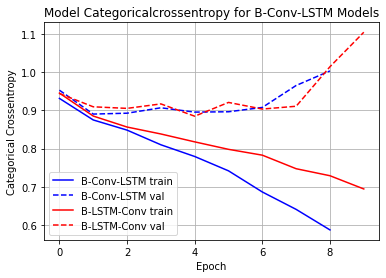

In [679]:
plot_model(model_cnn_bi_lstm_results, 'CategoricalCrossentropy', "B-Conv-LSTM")
add_model(model_bi_lstm_cnn_results, 'CategoricalCrossentropy', 'red')
plt.legend(['B-Conv-LSTM train', 'B-Conv-LSTM val', 'B-LSTM-Conv train', 'B-LSTM-Conv val'])

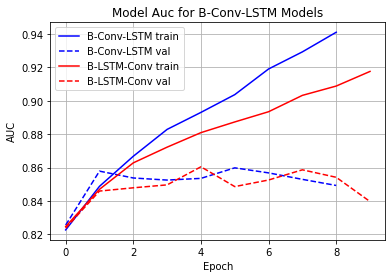

In [680]:
plot_model(model_cnn_bi_lstm_results, 'auc', "B-Conv-LSTM")
add_model(model_bi_lstm_cnn_results, 'auc', 'red')
plt.legend(['B-Conv-LSTM train', 'B-Conv-LSTM val', 'B-LSTM-Conv train', 'B-LSTM-Conv val'])

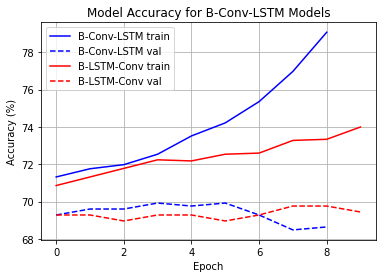

In [681]:
plot_model(model_cnn_bi_lstm_results, 'accuracy', "B-Conv-LSTM")
add_model(model_bi_lstm_cnn_results, 'accuracy', 'red')
plt.legend(['B-Conv-LSTM train', 'B-Conv-LSTM val', 'B-LSTM-Conv train', 'B-LSTM-Conv val'])

In [359]:
model_cnn_bi_lstm_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.931539,0.822690,0.713172,0.953034,0.825576,0.6928
1,0.875053,0.848758,0.717569,0.890461,0.857846,0.6960
2,0.848424,0.866757,0.719768,0.892733,0.853750,0.6960
3,0.810033,0.882819,0.725365,0.906930,0.852500,0.6992
4,0.779356,0.892989,0.735159,0.895633,0.853520,0.6976
5,0.741739,0.903604,0.742155,0.896500,0.859818,0.6992
6,0.686365,0.918954,0.753548,0.907844,0.856801,0.6928
7,0.640745,0.929188,0.769738,0.965389,0.852929,0.6848
8,0.586962,0.940923,0.790726,1.003560,0.849281,0.6864


In [367]:
model_bi_lstm_cnn_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.945384,0.824691,0.708575,0.944392,0.823735,0.6928
1,0.885275,0.846974,0.713172,0.909512,0.845931,0.6928
2,0.856508,0.862806,0.717769,0.905376,0.847878,0.6896
3,0.838320,0.872195,0.722367,0.917112,0.849635,0.6928
4,0.817675,0.880878,0.721767,0.884896,0.860447,0.6928
5,0.798078,0.887272,0.725365,0.920994,0.848601,0.6896
6,0.782806,0.893383,0.725964,0.903623,0.852542,0.6928
7,0.747288,0.903168,0.732760,0.910954,0.858637,0.6976
8,0.728928,0.908741,0.733360,1.014515,0.854165,0.6976
9,0.694282,0.917494,0.739956,1.104853,0.839653,0.6944


## Bidirectional GRU Model using RMSprop Optimisation

In [373]:
model_bi_gru2_rmsprop_results = pd.read_csv('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_gru2_rmsprop_twitter100.csv')

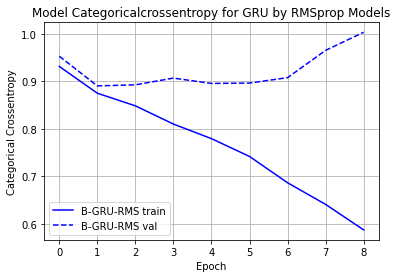

In [682]:
plot_model(model_cnn_bi_lstm_results, 'CategoricalCrossentropy', "GRU by RMSprop")
plt.legend(['B-GRU-RMS train', 'B-GRU-RMS val'])

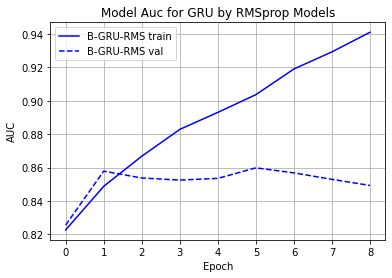

In [683]:
plot_model(model_cnn_bi_lstm_results, 'auc', "GRU by RMSprop")
plt.legend(['B-GRU-RMS train', 'B-GRU-RMS val'])

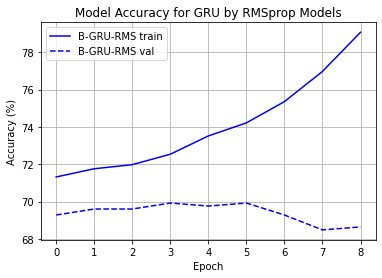

In [684]:
plot_model(model_cnn_bi_lstm_results, 'accuracy', "GRU by RMSprop")
plt.legend(['B-GRU-RMS train', 'B-GRU-RMS val'])

In [377]:
model_bi_gru2_rmsprop_results[['CategoricalCrossentropy', 'auc', 'accuracy', 'val_CategoricalCrossentropy', 'val_auc', 'val_accuracy']]

,CategoricalCrossentropy,auc,accuracy,val_CategoricalCrossentropy,val_auc,val_accuracy
0,0.992095,0.817926,0.701179,0.934458,0.824631,0.6928
1,0.916519,0.838137,0.715970,0.906713,0.843135,0.6960
2,0.895643,0.848916,0.718369,0.930155,0.842013,0.6880
3,0.888923,0.851246,0.719168,0.912952,0.846741,0.6976
4,0.866692,0.859867,0.723166,0.920231,0.847440,0.6960
5,0.858168,0.865449,0.719568,0.896752,0.852727,0.6992
6,0.851104,0.866056,0.723166,0.906229,0.849844,0.7024
7,0.842534,0.871040,0.721167,0.936602,0.847604,0.6944
8,0.836139,0.872022,0.723966,0.927490,0.849248,0.6960
9,0.816167,0.881225,0.723966,0.912068,0.854861,0.6976


# Predictions and Evaluation

## Selected Model

### Bidirectional GRU Model

In [719]:
model_bi_gru2.load_weights('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_gru2_twitter100.h5')

In [720]:
preds = model_bi_gru2.predict(X_test_pad)
predicted_categories = tf.argmax(preds, axis=1)

In [721]:
predicted_categories

<tf.Tensor: shape=(625,), dtype=int64, numpy=
array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
     

In [722]:
true_categories = tf.convert_to_tensor(category, dtype = 'int64')
true_categories = true_categories[-625:]
true_categories

<tf.Tensor: shape=(625,), dtype=int64, numpy=
array([0, 2, 3, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 3, 2, 0, 2, 0, 1,
       0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 3, 3, 2,
       0, 0, 0, 3, 0, 0, 0, 2, 0, 2, 1, 3, 3, 0, 0, 3, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 3, 0,
       0, 0, 0, 2, 3, 1, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 3, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 3, 2, 1, 1, 3, 0,
       3, 3, 2, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
     

#### Confusion Matrix

In [298]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_categories, predicted_categories)

array([[410,  18,   1,   2],
       [ 79,  14,   0,   0],
       [ 43,   0,   7,   0],
       [ 41,   0,   3,   7]])

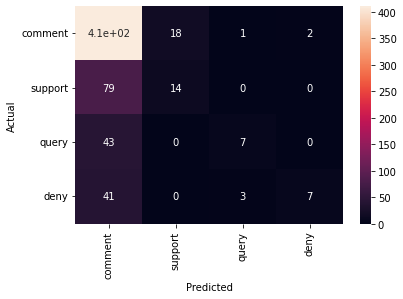

In [299]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

labels = ['comment', 'support', 'query', 'deny']

data = {'y_Actual':    true_categories,
        'y_Predicted': predicted_categories
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.yticks(np.arange(.5, 4.5), labels, rotation=0)
plt.xticks(np.arange(.5, 4.5), labels, rotation=90)
plt.show()

In [300]:
import sklearn
print(sklearn.metrics.classification_report(true_categories, predicted_categories, target_names=labels))

              precision    recall  f1-score   support

     comment       0.72      0.95      0.82       431
     support       0.44      0.15      0.22        93
       query       0.64      0.14      0.23        50
        deny       0.78      0.14      0.23        51

    accuracy                           0.70       625
   macro avg       0.64      0.34      0.38       625
weighted avg       0.67      0.70      0.63       625



#### Analysis of Model Mistakes

In [467]:
wrong_preds = true_categories != predicted_categories
wrong_preds[0:10]
res = [i for i, val in enumerate(wrong_preds) if val]

for sentence in np.arange(0,5):
  print(tokenizer_obj.sequences_to_texts(X_test_pad[res[sentence:sentence+1]]))
  print(">> true label -",labels[true_categories[res[sentence]]])
  print(">> predicted label -", labels[predicted_categories[res[sentence]]])
  print()

['skynews bollox']
>> true label - deny
>> predicted label - comment

['hanibathish colvinius martinrjay oh well as u may have noticed some ppl disagree with you']
>> true label - deny
>> predicted label - comment

['robstweeting daxtonbrown shamnaarai anewtrackrecord how do you know']
>> true label - query
>> predicted label - comment

['airsmolik my thoughts exactly rate is not unusual but surely crew were aware of where they were amp terrain this ll be interesting']
>> true label - support
>> predicted label - comment

['brwnskingirly cnnvideo no offense u sir but unless he was reaching a gun then there was no reason for this to happen']
>> true label - deny
>> predicted label - comment



In [507]:
comment = [i for i, val in enumerate(np.array(labels_wrong_preds)==0) if val]
support = [i for i, val in enumerate(np.array(labels_wrong_preds)==1) if val]
query = [i for i, val in enumerate(np.array(labels_wrong_preds)==2) if val]
deny = [i for i, val in enumerate(np.array(labels_wrong_preds)==3) if val]

In [544]:
for sentence in comment[0:8]:
  print(tokenizer_obj.sequences_to_texts(X_test_pad[res[sentence:sentence+1]]))
  print(">> true label -",labels[true_categories[res[sentence]]])
  print(">> predicted label -", labels[predicted_categories[res[sentence]]])
  print()

['babywash rtcom you are on crack your foolish comment invalidates any truth that may be buried within the nonsense']
>> true label - comment
>> predicted label - deny

['sad telegraph soldier killed in canada shooting was a young reservist with a old son http http tcopssqrirqmo']
>> true label - comment
>> predicted label - support

['michaelskolnik every hours a black male is killed in the united states by police or vigilantes ferguson that is sad']
>> true label - comment
>> predicted label - support

['this michaelskolnik every hours a black male is killed in the united states by police or vigilantes ferguson']
>> true label - comment
>> predicted label - support

['wow michaelskolnik every hours a black male is killed in the united states by police or vigilantes ferguson']
>> true label - comment
>> predicted label - support

['rt michaelskolnik every hours a black male is killed in the united states by police or vigilantes ferguson']
>> true label - comment
>> predicted label - s

In [545]:
for sentence in support[0:8]:
  print(tokenizer_obj.sequences_to_texts(X_test_pad[res[sentence:sentence+1]]))
  print(">> true label -",labels[true_categories[res[sentence]]])
  print(">> predicted label -", labels[predicted_categories[res[sentence]]])
  print()

['airsmolik my thoughts exactly rate is not unusual but surely crew were aware of where they were amp terrain this ll be interesting']
>> true label - support
>> predicted label - comment

['michaelskolnik shooting related to protesting ppl on the street are upset about this also pregnant woman forced facedown on ground']
>> true label - support
>> predicted label - comment

['larryelder http']
>> true label - support
>> predicted label - comment

['translation killing unarmed teen his first mt yamiche darren wilson vet of ferguson police w no disciplinary actions against him']
>> true label - support
>> predicted label - comment

['wsjlive this is a small lesson to canada on human rights what it was trying to preach to india in last yrs']
>> true label - support
>> predicted label - comment

['zellieimani how many white celebrities have been caught shoplifting and end up dead in streets i ll wait ferguson even oj lol']
>> true label - support
>> predicted label - comment

['cnnvideo o

In [546]:
for sentence in query[0:8]:
  print(tokenizer_obj.sequences_to_texts(X_test_pad[res[sentence:sentence+1]]))
  print(">> true label -",labels[true_categories[res[sentence]]])
  print(">> predicted label -", labels[predicted_categories[res[sentence]]])
  print()

['robstweeting daxtonbrown shamnaarai anewtrackrecord how do you know']
>> true label - query
>> predicted label - comment

['pascalsyn airlivenet but isn t declaring an emergency the proper procedure if you still have control of the situation']
>> true label - query
>> predicted label - comment

['cnnvideo cnn lol cnn is first to report this did you find that plane yet']
>> true label - query
>> predicted label - comment

['marksutcliffe thanks mark are you in ottawa stay safe']
>> true label - query
>> predicted label - comment

['andybankertv and the store owner and the pictures say it was nt why does someone who did nt see it matter']
>> true label - query
>> predicted label - comment

['joycekaram is he consider as terrorist or just a criminal person as his faith not sunni islam']
>> true label - query
>> predicted label - comment

['dmeralles clydetheslyde http']
>> true label - query
>> predicted label - comment

['dianazoga antoniofrench how were the police so quick to indicate

In [547]:
for sentence in deny[0:8]:
  print(tokenizer_obj.sequences_to_texts(X_test_pad[res[sentence:sentence+1]]))
  print(">> true label -",labels[true_categories[res[sentence]]])
  print(">> predicted label -", labels[predicted_categories[res[sentence]]])
  print()

['skynews bollox']
>> true label - deny
>> predicted label - comment

['hanibathish colvinius martinrjay oh well as u may have noticed some ppl disagree with you']
>> true label - deny
>> predicted label - comment

['brwnskingirly cnnvideo no offense u sir but unless he was reaching a gun then there was no reason for this to happen']
>> true label - deny
>> predicted label - comment

['colvinius martinrjay it s not a matter of criticism it s insulting and demeaning and offensive']
>> true label - deny
>> predicted label - comment

['edeweysmith we need b careful of jumping conclusions waiting to see this videotape']
>> true label - deny
>> predicted label - comment

['nice linkbait rtcom but does a report of a suicide belt really rate a headline like your tweet sydneysiege http']
>> true label - deny
>> predicted label - comment

['mashable uber is facing problems enough will a price hike really help']
>> true label - deny
>> predicted label - comment

['davebeninger cherylnorrad ugh c

## Alternative Models

### Bidirectional LSTM Model

In [302]:

model_bi_lstm.load_weights('/content/drive/MyDrive/COSC2779/Assessment_2/model_bi_lstm_twitter100.h5')

In [303]:
preds = model_bi_lstm.predict(X_test_pad)
preds = preds
predicted_categories = tf.argmax(preds, axis=1)

In [304]:
predicted_categories

<tf.Tensor: shape=(625,), dtype=int64, numpy=
array([0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 0, 0, 0, 0, 1, 0, 0, 3, 2, 0,
       0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 3, 0, 0, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
     

In [305]:
true_categories = tf.convert_to_tensor(category, dtype = 'int64')
true_categories = true_categories[-625:]
true_categories

<tf.Tensor: shape=(625,), dtype=int64, numpy=
array([0, 2, 3, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 3, 2, 0, 2, 0, 1,
       0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 3, 3, 2,
       0, 0, 0, 3, 0, 0, 0, 2, 0, 2, 1, 3, 3, 0, 0, 3, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 3, 0,
       0, 0, 0, 2, 3, 1, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 3, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 3, 2, 1, 1, 3, 0,
       3, 3, 2, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
     

#### Confusion Matrix

In [306]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_categories, predicted_categories)

array([[382,  28,   8,  13],
       [ 62,  23,   4,   4],
       [ 38,   1,  10,   1],
       [ 40,   1,   3,   7]])

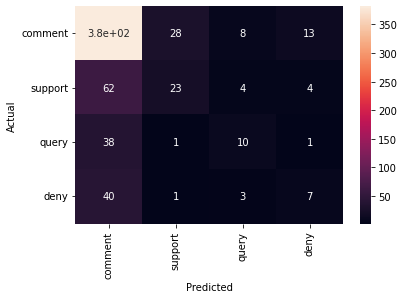

In [307]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

labels = ['comment', 'support', 'query', 'deny']

data = {'y_Actual':    true_categories,
        'y_Predicted': predicted_categories
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.yticks(np.arange(.5, 4.5), labels, rotation=0)
plt.xticks(np.arange(.5, 4.5), labels, rotation=90)
plt.show()

In [308]:
import sklearn
print(sklearn.metrics.classification_report(true_categories, predicted_categories, target_names=labels))

              precision    recall  f1-score   support

     comment       0.73      0.89      0.80       431
     support       0.43      0.25      0.32        93
       query       0.40      0.20      0.27        50
        deny       0.28      0.14      0.18        51

    accuracy                           0.68       625
   macro avg       0.46      0.37      0.39       625
weighted avg       0.62      0.68      0.64       625



In [309]:
labels = ['comment', 'support', 'query', 'deny']

### Simple LSTM Model

In [378]:
model_lstm.load_weights('/content/drive/MyDrive/COSC2779/Assessment_2/model_lstm_twitter100.h5')

In [379]:
preds = model_lstm.predict(X_test_pad)
preds = preds
predicted_categories = tf.argmax(preds, axis=1)

In [380]:
predicted_categories

<tf.Tensor: shape=(625,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 3, 2, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 3, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
     

In [381]:
true_categories = tf.convert_to_tensor(category, dtype = 'int64')
true_categories = true_categories[-625:]
true_categories

<tf.Tensor: shape=(625,), dtype=int64, numpy=
array([0, 2, 3, 3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 2, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 3, 2, 0, 2, 0, 1,
       0, 0, 0, 0, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 3, 3, 2,
       0, 0, 0, 3, 0, 0, 0, 2, 0, 2, 1, 3, 3, 0, 0, 3, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 3, 0,
       0, 0, 0, 2, 3, 1, 3, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 3, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 3, 2, 1, 1, 3, 0,
       3, 3, 2, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
     

#### Confusion Matrix

In [382]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_categories, predicted_categories)

array([[385,  33,   7,   6],
       [ 68,  21,   2,   2],
       [ 43,   1,   6,   0],
       [ 38,   3,   3,   7]])

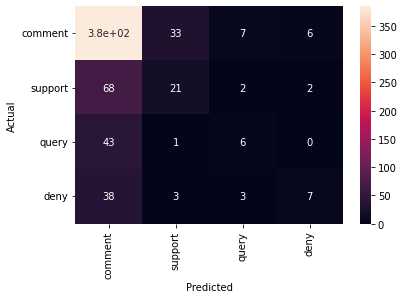

In [383]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

labels = ['comment', 'support', 'query', 'deny']

data = {'y_Actual':    true_categories,
        'y_Predicted': predicted_categories
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.yticks(np.arange(.5, 4.5), labels, rotation=0)
plt.xticks(np.arange(.5, 4.5), labels, rotation=90)
plt.show()

In [384]:
import sklearn
print(sklearn.metrics.classification_report(true_categories, predicted_categories, target_names=labels))

              precision    recall  f1-score   support

     comment       0.72      0.89      0.80       431
     support       0.36      0.23      0.28        93
       query       0.33      0.12      0.18        50
        deny       0.47      0.14      0.21        51

    accuracy                           0.67       625
   macro avg       0.47      0.34      0.37       625
weighted avg       0.62      0.67      0.62       625

